### Стандартизированные генераторы графиков

In [9]:
from email.utils import parsedate
from json import loads

import matplotlib.pyplot as plt


def plot(x, y, graph_settings):
    plt.figure(figsize=(15, 8))
    plt.xlabel(graph_settings['x_name'], fontsize=13)
    plt.ylabel(graph_settings['y_name'], fontsize=13)
    plt.title(graph_settings['title'])
    plt.plot(x, y)
    plt.grid()
    plt.savefig(graph_settings['file_name'], bbox_inches='tight')
    plt.show()


def bar_chart_for_groups(groups, group_dictionary, graph_settings):
    group_cnt = sorted(
        list({i.replace(i[0], group_dictionary[i[0]] + '-'): groups.count(i) for i in set(groups)}.items()),
        key=lambda arr: arr[1])

    x = tuple(i for i, _ in group_cnt)
    y = tuple(j for _, j in group_cnt)

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.ylabel(graph_settings['y_name'], fontsize=18)
    plt.xlabel(graph_settings['x_name'], fontsize=18)
    ax.set_title(graph_settings['title'], fontdict={'fontsize': 25})
    ax.set_facecolor('seashell')
    fig.set_facecolor('floralwhite')
    fig.set_figwidth(graph_settings['size'][0])
    fig.set_figheight(graph_settings['size'][1])
    plt.savefig(graph_settings['file_name'], bbox_inches='tight')
    plt.show()

def circle_diagram(main_list, label_list, graph_settings):
    _, ax1 = plt.subplots(1, figsize=graph_settings['size'])
    ax1.pie(main_list, shadow=True, radius=1.4, textprops={'fontsize': 15})
    ax1.legend(fontsize=15, labels=label_list)
    ax1.set_title(graph_settings['title'], y=1.1, fontdict={'fontsize': 25})
    plt.savefig(graph_settings['file_name'], bbox_inches='tight')
    plt.show()

### Построение графика дневной активности студентов по данным с файла messages.json

In [10]:
def plotting_student_activity_during_a_day(messages):
    messages = [(m['subj'].upper(), parsedate(m['date'])[1:6]) for m in messages]
    time_schedule = [time[2:-1] for _, time in messages]
    time_schedule.sort(key=lambda arr: arr[0] * 3600 + arr[1] * 60)
    s = len(time_schedule)

    hours = {str(i) + ':00': 100 * len([x for x in range(len(time_schedule)) if
                                        (time_schedule[x][1] < 30 and time_schedule[x][0] == i
                                         or time_schedule[x - 1][1] >= 30 and
                                         time_schedule[x][0] == i - 1)]) / s
             for i in range(24)}
    hours['0:00'] += 100 * len([j for i, j in time_schedule if i == 23 and j >= 30]) / s
    settings = {
        'title': 'Activity during a day',
        'file_name': 'graph_collector/Activity_during_a_day.png',
        'size': [25, 15],
        'y_name': 'Activity, %',
        'x_name': 'Time',
    }
    plot(hours.keys(), hours.values(), settings)

### Построение графика активности студентов в течение недели на основе данных с файла messages.json

In [11]:
def plotting_student_activity_during_a_week(messages):
    days = ('Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat')

    dates = tuple(x['date'].split(',')[0] for x in messages)
    count = tuple((day, dates.count(day)) for day in days)
    settings = {
        'title': 'Activity during a week',
        'file_name': 'graph_collector/Activity_during_a_week.png',
        'size': [25, 15],
        'y_name': 'Activity, %',
        'x_name': 'Days',
    }
    y = tuple(x for _, x in count)
    s = sum(y)
    y = tuple(float("{0:.2f}".format(100 * x / s)) for x in y)
    plot(days, y, settings)

### Построение графика активности групп, расчитываемой по отправленным запросам на проверку

In [12]:
def plotting_groups_with_the_most_messages_sent(messages, group_dictionary):
    settings = {
        'title': 'Most messages sent',
        'file_name': 'graph_collector/Most_messages_sent.png',
        'size': [45, 10],
        'y_name': 'Messages sent',
        'x_name': 'Group',
    }
    bar_chart_for_groups(
        [grs.split()[0] for grs, _ in [(m['subj'].upper(), parsedate(m['date'])[1:6]) for m in messages]],
        group_dictionary,
        settings)

### Построение графика завершенных заданий, расчитываемых по группам

In [13]:
def plotting_hard_working_groups(inp, group_dictionary):
    settings = {
        'title': 'Most hard-working groups',
        'file_name': 'graph_collector/Hard-working_groups.png',
        'size': [45, 10],
        'y_name': 'Tasks completed',
        'x_name': 'Group',
    }
    bar_chart_for_groups([grs[0] for grs in inp['data'] if grs[3]], group_dictionary, settings)

### Построение графика сложности заданий на основе расчета неверно решенных к верным

In [14]:
def plotting_the_easiest_and_hardest_tasks(inp):
    tasks = [(tsk[2], tsk[3]) for tsk in inp['data']]

    tasks = {tsk[0]: float(
        "{0:.1f}".format(100 * (tasks.count((tsk[0], 0))
                                / (tasks.count((tsk[0], 1)) - tasks.count((tsk[0], 0)))))) for tsk in tasks}
    tasks = list(tasks.items())
    tasks.sort(key=lambda arr: arr[1])

    settings = {
        'title': 'Tasks from the easiest to the hardest one',
        'file_name': 'graph_collector/Tasks_complexity.png',
        'size': [25, 15],
        'y_name': 'Complexity, %',
        'x_name': 'Task, №',
    }
    plot(tuple(i for i, _ in tasks),
         tuple(j for _, j in tasks),
         settings)

### Построение графика наиболее часто совершаемых ошибок

In [15]:
def plotting_common_mistakes(report):
    ans = [i for i, _ in report.values()]
    for_bit = [i for _, i in report.values() if 'побитовые операции' in str(i)]

    mistakes = {'None': 0,
                'list index out of range': 0,
                'is not defined': 0,
                'unused bit operations': len(for_bit),
                'unsupported operand type': 0,
                'positional arguments': 0,
                'no attribute': 0,
                'wrong answer': 0,
                'referenced before assignment': 0
                }
    for a in ans:
        for mistake in mistakes:
            if a == 'None':
                mistakes['None'] += 1
                break
            elif mistake in str(a):
                mistakes[mistake] += 1
            else:
                mistakes['wrong answer'] += 1

    settings = {
        'title': 'The most common mistakes made',
        'file_name': 'graph_collector/Common_mistakes.png',
        'size': [15, 10],
        'y_name': 'Tasks completed',
        'x_name': 'Group',
    }
    circle_diagram(main_list=mistakes.values(), label_list=mistakes.keys(), graph_settings=settings)

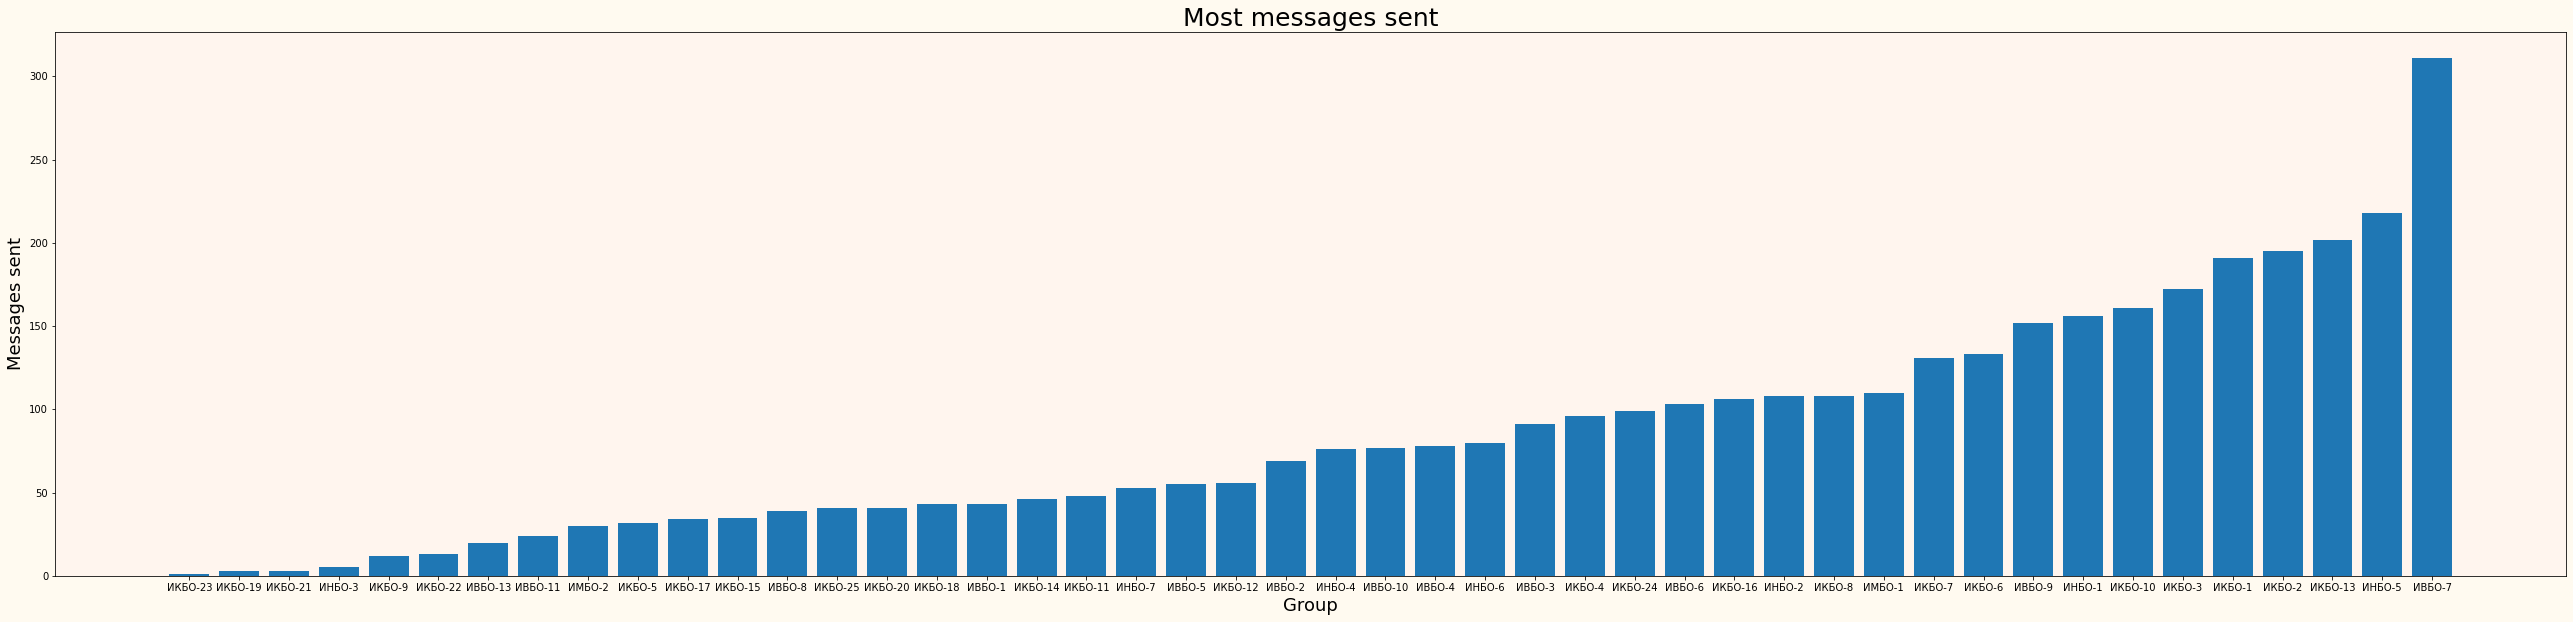

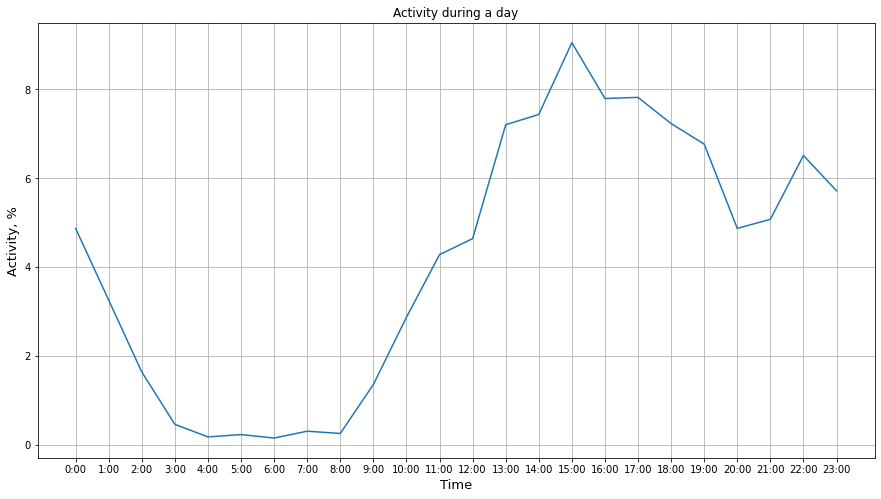

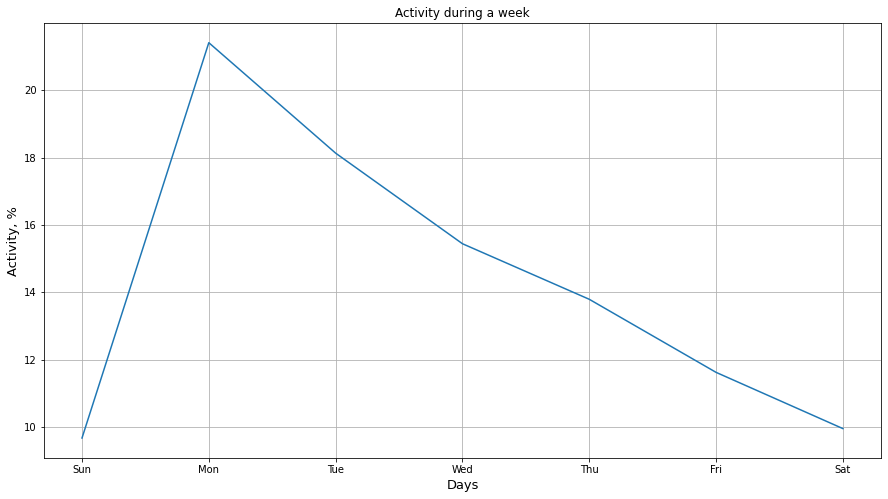

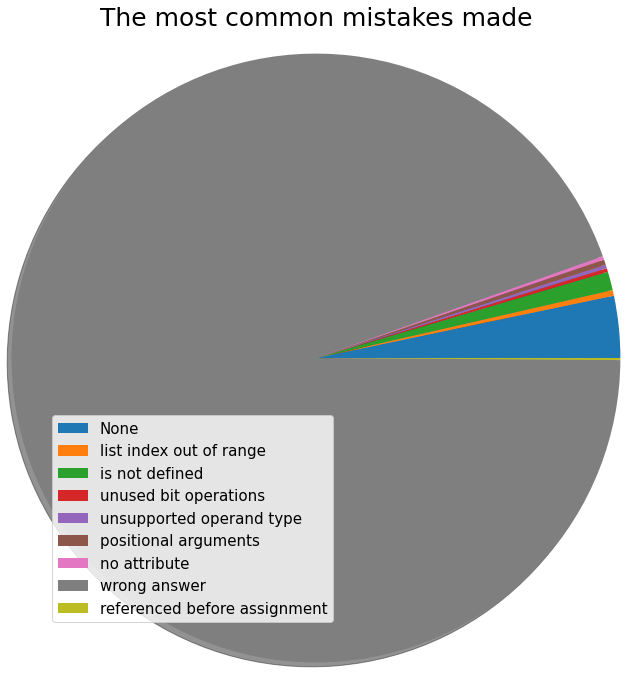

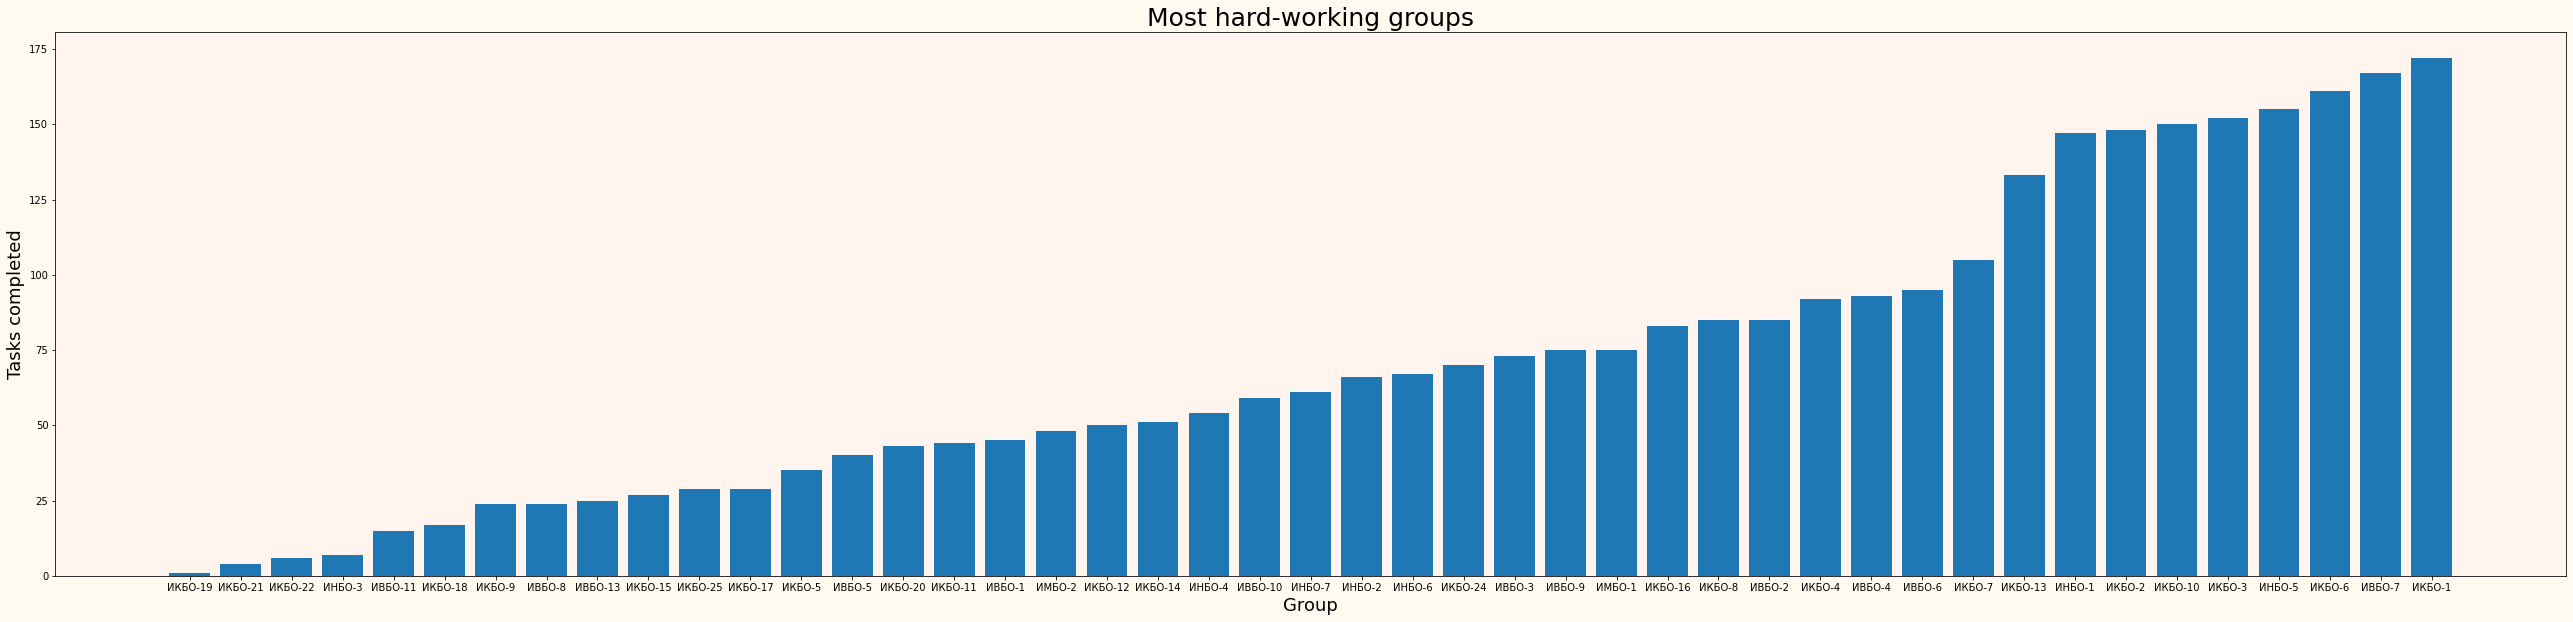

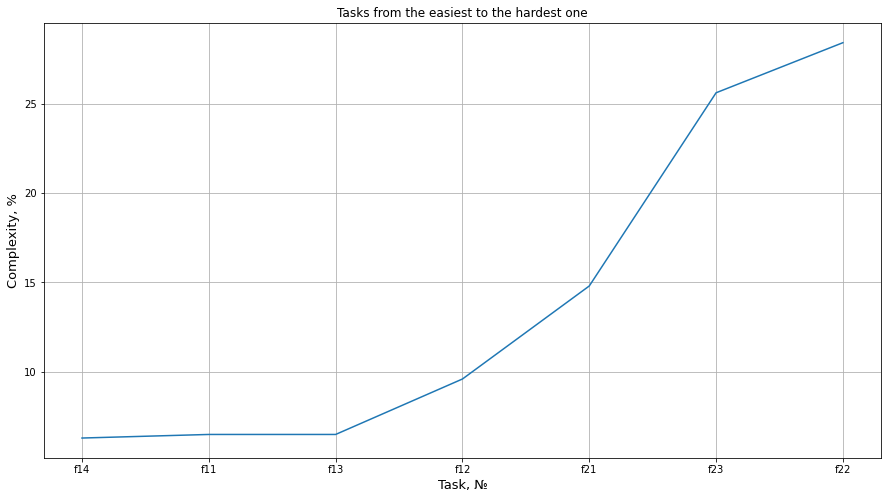

In [16]:
if __name__ == '__main__':
    group_dict = {'К': 'ИКБО', 'В': 'ИВБО', 'Н': 'ИНБО', 'М': 'ИМБО'}

    with open('messages.json', encoding='utf8') as f:
        ms = loads(f.read())
        plotting_groups_with_the_most_messages_sent(ms, group_dict)
        plotting_student_activity_during_a_day(ms)
        plotting_student_activity_during_a_week(ms)

    with open('failed.json', encoding='utf8') as f:
        failed = loads(f.read())
        plotting_common_mistakes(failed)

    with open('table.json', encoding='utf8') as f:
        table = loads(f.read())
        plotting_hard_working_groups(table, group_dict)
        plotting_the_easiest_and_hardest_tasks(table)